# Visual Reasoning Baseline Model
 - https://huggingface.co/blog/fine-tune-vit

1. Data preprocessing 어떻게 하면될까?
 - Image feature를 resnet으로 미리 추출해둘까? --> baseline돌리기 까다로움
 - DataLoader 구성을 어떻게하면 좋을까? --> DataSet class 안에서 feature를 return 할까? 아니면 ResNet을 밖에둘까


2. Baseline Model 설계를 어떻게?
 - Encoder: image encoding 어떻게 하면 될까? Answer Image 3개를 한꺼번에 encoding? 혹은 각각 encoding 한 후 Weight Sum??
 - Decoder: Answer 후보 중 정답후보를 어떻게 고를까? Similarity 기준? KL 같은 분포기준? Attention 기반 Scoring??


3. SOTA Model 설계를 어떻게? 

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

## 1. Import all packages

In [2]:
import pandas as pd
import numpy as np
import json
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision
import torch.optim as optim
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from PIL import Image
from PIL import Image, ImageDraw
import cv2
from transformers import ViTFeatureExtractor, ViTModel

import matplotlib
import matplotlib.pyplot as plt
#import matplotlib.font_manager as fm
#fm.get_fontconfig_fonts()
#font_location = './NanumGothic.ttf'
#font_location = 'C:/Windows/Fonts/NanumGothic.ttf' # For Windows
#font_name = fm.FontProperties(fname=font_location).get_name()
#matplotlib.rc('font', family=font_name)

%matplotlib inline
# 브라우저에서 바로 이미지를 그린다.


In [3]:
'''
nrows,ncols=6,15
fig,ax = plt.subplots(nrows,ncols,figsize=(15,6))
plt.subplots_adjust(wspace=0, hspace=0) 
for i,j in enumerate(malignant[:nrows*ncols]):
    fname = os.path.join(imgpath ,j +'.tif')
    img = Image.open(fname)
    idcol = ImageDraw.Draw(img)
    idcol.rectangle(((0,0),(95,95)),outline='red')
    plt.subplot(nrows, ncols, i+1) 
    plt.imshow(np.array(img))
    plt.axis('off')
    
import plotly.express as px

# Create grid of sample images 
grid_size=30
rnd_inds=np.random.randint(0,len(train_ts),grid_size)
print("image indices:",rnd_inds)

x_grid_train=[train_ts[i][0] for i in rnd_inds]
y_grid_train=[train_ts[i][1] for i in rnd_inds]

x_grid_train=utils.make_grid(x_grid_train, nrow=10, padding=2)
print(x_grid_train.shape)
    
plot_img(x_grid_train,y_grid_train,'Training Subset Examples')
image indices: [1438  355 2681 1007 2970 2925  605 1739  270 1641 1080  786 1840   62
 2633  734 1712  511 2681 2973  180 2601  500 1959  869    3 2359 3153
  345 1307]
torch.Size([3, 146, 482])

'''

'\nnrows,ncols=6,15\nfig,ax = plt.subplots(nrows,ncols,figsize=(15,6))\nplt.subplots_adjust(wspace=0, hspace=0) \nfor i,j in enumerate(malignant[:nrows*ncols]):\n    fname = os.path.join(imgpath ,j +\'.tif\')\n    img = Image.open(fname)\n    idcol = ImageDraw.Draw(img)\n    idcol.rectangle(((0,0),(95,95)),outline=\'red\')\n    plt.subplot(nrows, ncols, i+1) \n    plt.imshow(np.array(img))\n    plt.axis(\'off\')\n    \nimport plotly.express as px\n\n# Create grid of sample images \ngrid_size=30\nrnd_inds=np.random.randint(0,len(train_ts),grid_size)\nprint("image indices:",rnd_inds)\n\nx_grid_train=[train_ts[i][0] for i in rnd_inds]\ny_grid_train=[train_ts[i][1] for i in rnd_inds]\n\nx_grid_train=utils.make_grid(x_grid_train, nrow=10, padding=2)\nprint(x_grid_train.shape)\n    \nplot_img(x_grid_train,y_grid_train,\'Training Subset Examples\')\nimage indices: [1438  355 2681 1007 2970 2925  605 1739  270 1641 1080  786 1840   62\n 2633  734 1712  511 2681 2973  180 2601  500 1959  869   

## 2. Preparation of datasets

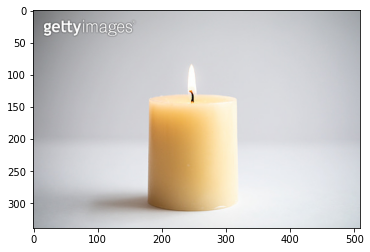

In [4]:
class Config:
    def __init__(self, args=None):
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.distributed = False
        self.gpu_id = "0,1"
        self.HOME_DIR = "./datasets/"
        self.TASK_NAME = "similarity1/"
        self.FOLDER_NAME = "000003/"
        self.IMAGE_LIST = [
                "0d73dee440ef4291ae926fb5cb4ec55e.jpg", 
                "18f827e0d01742d495d3ecbaffb6255a.jpg", 
                "1b243a095866423da8f4a8f19d78ecf4.jpg",
                "4db9fa5bd947497d91bffd8de3b07e6e.jpg",
                "95ac10e3608e4abba9407a2a1cae2883.jpg",
                "a05e9630fd754a249b1fba0be5f386ed.jpg",
                "ea1f8a29ba464af4b2b393d4bb50d7c0.jpg"
             ]
        self.JSON_NAME = "000003"+".json"
        self.input_dim = 768
        self.mlp_hidden = 1024


config = Config()
a_image_file = config.HOME_DIR+config.TASK_NAME+config.FOLDER_NAME+config.IMAGE_LIST[0]
a_image = plt.imread(a_image_file)
plt.imshow(a_image)

In [5]:
def mixup(a1, a2):

    n, p = 1, .5
    new_answer = np.random.binomial(n, p, 1) ## Generate a new answer
    new_answer1 = a1 if new_answer==0 else a2
    new_answer2 = a2 if new_answer==0 else a1

    return pd.Series([new_answer1, new_answer2, new_answer])

def get_data(config):
    
    home_dir = config.HOME_DIR
    task_name = config.TASK_NAME
    dir_list = os.listdir(home_dir+task_name)
    sample_list = []
    
    for directory in dir_list:
        FOLDER_NAME = directory+"/"
        JSON_NAME = directory+".json"
        FILE_PATH = home_dir+task_name+FOLDER_NAME
        a_data = json.load(open(FILE_PATH+JSON_NAME))
        a_data["file_path"] = FILE_PATH
        a_data["answer1"] = [a_data["Answers"][0]]
        a_data["answer2"] = [a_data["Answers"][1]]
        del a_data["Answers"]
        sample_list.append(a_data)
        
        df = pd.DataFrame(sample_list)

    df[['answer1', 'answer2', 'correct_answer_group_ID']] = df.apply(lambda x: mixup(x["answer1"], x["answer2"]), axis = 1)
    df.drop(df[df["doc_id"] == "000769"].index, inplace=True)
    df.drop(df[df["doc_id"] == "000256"].index, inplace=True)
        
    return df

def get_img_argumentation():
    #이미지 전처리를 위한 이미지 크기 변환 및 각도조정을 위한 transform 선언

    transform = transforms.Compose(
        [
            transforms.Resize((356, 356)),
            transforms.RandomCrop((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    )
    
    return transform


In [76]:
class Similarity1_Dataset(torch.utils.data.Dataset):
    
    def __init__(self, df, config=None, transform=None):
        self.df = df
        self.config = config
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
        
    def __getitem__(self, idx):
        sample = self.df.iloc[idx]
        
        target = sample["correct_answer_group_ID"][0]
        category = sample["category"]
        q_img = sample["file_path"] + sample["Questions"][0]["images"][0]["image_url"]
        a1_img = [sample["file_path"] + ans_img["image_url"] for ans_img in sample["answer1"][0]["images"]]
        a2_img = [sample["file_path"] + ans_img["image_url"] for ans_img in sample["answer2"][0]["images"]]
        
        q_img_feature = Image.open(q_img).convert('RGB')  #이미지 데이터를 RGB형태로 읽음 
        q_img_feature = self.transform(q_img_feature, return_tensors="pt")  #이미지 데이터의 크기 및 각도등을 변경
        
        # remove batch dimension
        for k,v in q_img_feature.items():
          q_img_feature[k] = v.squeeze()
        # add labels
        
        a1_img_feature = [self.transform(Image.open(img).convert('RGB'), return_tensors="pt") for img in a1_img]
        
        for img in a1_img_feature:
            # remove batch dimension
            for k,v in img.items():
              img[k] = v.squeeze()
            # add labels
        
        a2_img_feature = [self.transform(Image.open(img).convert('RGB'), return_tensors="pt") for img in a2_img]
        
        for img in a2_img_feature:
            # remove batch dimension
            for k,v in img.items():
              img[k] = v.squeeze()
            # add labels
        
        return {
            "target": target,
            "q_img": q_img_feature,
            "a1_imgs": a1_img_feature,
            "a2_imgs": a2_img_feature
        }
        
    

In [77]:
def make_sequential(in_channels, out_channels, *args, **kwargs):
    return nn.Sequential(nn.Conv2d(in_channels, out_channels, *args, **kwargs),
           nn.BatchNorm2d(out_channels),
           nn.ReLu(),
           nn.MaxPool2d(*args, **kwargs))

class VRSimilarity(nn.Module):
    def __init__(self, config):
        super(VRSimilarity, self).__init__()
        
        self.config = config
        self.backborne = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k").to(self.config.device)
        #self.backborne = torchvision.models.resnet50(pretrained=True)
        #self.backborne.fc = nn.Linear(self.backborne.fc.in_features, self.config.input_dim)
        self.fc = nn.Sequential(
                    nn.Linear(self.config.input_dim*4, self.config.mlp_hidden),
                    nn.ReLU(),
                    nn.Dropout(0.2),
                    nn.Linear(self.config.mlp_hidden, self.config.mlp_hidden),
        )
        self.classfier = nn.Sequential(
                    nn.Linear(self.config.mlp_hidden*2, self.config.mlp_hidden),
                    nn.ReLU(),
                    nn.Dropout(0.2),
                    nn.Linear(self.config.mlp_hidden, 2),
        )

    def forward(self, samples):
        
        #Question Image Feature
        q = self.backborne(**samples["q_img"])[0,0,:]
        
        #Answer1 Image Feature
        a1_img1 = self.backborne(**samples["a1_imgs"][0])[0,0,:]
        a1_img2 = self.backborne(**samples["a1_imgs"][1])[0,0,:]
        a1_img3 = self.backborne(**samples["a1_imgs"][2])[0,0,:]
        
        #Answer2 Image Feature
        a2_img1 = self.backborne(**samples["a2_imgs"][0])[0,0,:]
        a2_img2 = self.backborne(**samples["a2_imgs"][1])[0,0,:]
        a2_img3 = self.backborne(**samples["a2_imgs"][2])[0,0,:]
        
        q_a1 = torch.cat([q, a1_img1, a1_img2, a1_img3], axis=1)
        q_a2 = torch.cat([q, a2_img1, a2_img2, a2_img3], axis=1)
        
        q_a1_logit = self.fc(q_a1)
        q_a2_logit = self.fc(q_a2)
        
        q_a1_a2_logit = torch.cat([q_a1_logit, q_a2_logit], axis=1)
        logit = self.classfier(q_a1_a2_logit)
        
        return logit


In [78]:
def train_fn(model, train_loader, optimizer, loss_fn, config):
    
    total_count_correct = 0
    total_num_example = 0
    total_loss = []
    
    model.train()
    device = config.device
    
    for batch in tqdm(train_loader):          
        
        #Question Image Feature
        batch["q_img"] = batch["q_img"].to(device)
        
        #Answer1 Image Feature
        batch["a1_imgs"][0] = batch["a1_imgs"][0].to(device)
        batch["a1_imgs"][1] = batch["a1_imgs"][1].to(device)
        batch["a1_imgs"][2] = batch["a1_imgs"][2].to(device)
        
        #Answer2 Image Feature
        batch["a2_imgs"][0] = batch["a2_imgs"][0].to(device)
        batch["a2_imgs"][1] = batch["a2_imgs"][1].to(device)
        batch["a2_imgs"][2] = batch["a2_imgs"][2].to(device)
        
        logit = model(batch)

        target = batch["target"].long().to(device)
        loss = loss_fn(logit, target)
        total_loss.append(loss.item())
        
        predicted = logit.argmax(dim=1, keepdim=True).squeeze()
        total_count_correct = total_count_correct + torch.sum(predicted == target).item()
        total_num_example = total_num_example + target.size(0)

        print(logit)
        print(predicted)
        print(target)
        print(predicted == target)
        print(loss)

        print("total_count_correct", total_count_correct)
        print("total_num_example", total_num_example)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print("LOSS:", str(sum(total_loss)/total_num_example) + " Accuracy: " + str(total_count_correct/total_num_example) )


In [79]:
config = Config()

df = get_data(config)
train_df, test_df = train_test_split(df)
#transform = get_img_argumentation() #for ResNet
model_name_or_path = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path) 
transform = feature_extractor #for VIT
train_datasets = Similarity1_Dataset(train_df, transform=transform)
train_loader = torch.utils.data.DataLoader(train_datasets, batch_size=4)

vrs1_model = VRSimilarity(config)
#vrs1_model = torch.nn.DataParallel(vrs1_model)
vrs1_model = vrs1_model.to(config.device)
if config.distributed:
    #vrs1_model = torch.nn.parallel.DistributedDataParallel(vrs1_model, device_ids=[config.gpu])    
    vrs1_model = torch.nn.parallel.DistributedDataParallel(vrs1_model)    

optimizer = torch.optim.Adam(vrs1_model.parameters(), lr=0.008)
#loss_fn = nn.BCELoss()
loss_fn = nn.CrossEntropyLoss()


In [80]:
#for idx in range(200):
train_fn(vrs1_model, train_loader, optimizer, loss_fn, config)

  0%|          | 0/592 [00:00<?, ?it/s]


TypeError: tuple indices must be integers or slices, not tuple

In [ ]:
df["category"].value_counts()

In [ ]:
df

In [33]:
from datasets import load_dataset

In [34]:
dataset = load_dataset("huggingface/cats-image")

No config specified, defaulting to: cats_image/image
Reusing dataset cats_image (/root/.cache/huggingface/datasets/huggingface___cats_image/image/1.9.0/68fbc793fb10cd165e490867f5d61fa366086ea40c73e549a020103dcb4f597e)


  0%|          | 0/1 [00:00<?, ?it/s]

In [35]:
image = dataset["test"]["image"][0]

In [38]:
model_name_or_path = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path) 
backborne = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")

In [41]:
inputs = feature_extractor(image, return_tensors="pt")
#print(inputs)
print(inputs["pixel_values"].size())
backborne(**inputs)

torch.Size([1, 3, 224, 224])


BaseModelOutputWithPooling(last_hidden_state=tensor([[[ 0.1559,  0.0914,  0.1518,  ..., -0.3180, -0.0859, -0.0903],
         [-0.2254,  0.0864,  0.4752,  ..., -0.1781,  0.1726,  0.1334],
         [ 0.0444,  0.0677,  0.4199,  ..., -0.2576,  0.1191,  0.0130],
         ...,
         [-0.0153, -0.0396,  0.1684,  ..., -0.1672,  0.1869,  0.1025],
         [ 0.0249, -0.0382,  0.2046,  ...,  0.0517,  0.1489,  0.1320],
         [-0.1748, -0.0254,  0.2523,  ..., -0.1474,  0.1627,  0.1325]]],
       grad_fn=<NativeLayerNormBackward0>), pooler_output=tensor([[ 5.8399e-02, -3.0683e-01,  3.1213e-01, -1.1009e-01, -1.4752e-01,
          4.9735e-01, -1.5786e-01,  4.8658e-01, -4.6255e-01,  2.4344e-01,
          2.9942e-02,  2.8738e-01, -4.8914e-01, -9.9519e-03, -2.8943e-01,
          3.1443e-01, -6.2883e-02, -2.6637e-01, -3.9652e-01,  2.9896e-01,
          2.1507e-01, -1.9265e-01,  1.1786e-01,  2.5995e-01,  3.5440e-01,
         -3.7968e-01,  4.8320e-01, -3.5686e-01,  2.3996e-01, -8.0731e-01,
          1

In [75]:
for batch in tqdm(train_loader):          

    batch["q_img"] = batch["q_img"]
    #batch["q_img"] = batch["q_img"]["pixel_values"].squeeze()
    print(batch["q_img"])
    out = backborne(**batch["q_img"])
    print(out.last_hidden_state[:,0,:].size())
    break

  0%|          | 0/592 [00:00<?, ?it/s]

{'pixel_values': tensor([[[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          ...,
          [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000]],

         [[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          ...,
          [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000]],

         [[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [ 1

  0%|          | 0/592 [00:00<?, ?it/s]

torch.Size([4, 768])
